In [2]:
import os
import re
import pdb
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 800
plt.rcParams['savefig.dpi'] = 800

In [2]:
all_domains = set()
def collect_data(err_rate):
    runtimes = []
    mem_usages = []
    plan_lengths = []
    diagnosis_sizes = []
    for domain_name in os.listdir(os.getcwd()):
        domain_dir = os.path.join(os.getcwd(), domain_name)
        if not os.path.isdir(domain_dir):
            continue
        dm = domain_name.split("-")[0]
        all_domains.add(dm)
        for task_name in os.listdir(domain_dir):
            task_dir = os.path.join(domain_dir, task_name)
            if not os.path.exists(os.path.join(task_dir, "sas_plan")):
                continue
            if not os.path.exists(os.path.join(task_dir, "err-rate-{}".format(err_rate), "diagnosis")):
                continue
            with open(os.path.join(task_dir, "sas_plan"), "r") as f:
                plan_lengths.append(len(f.readlines()))
            with open(os.path.join(task_dir, "err-rate-{}".format(err_rate), "diagnosis"), "r") as f:
                lines = [line for line in f.readlines() if line.strip()]
            mem_info = lines.pop(-1)
            mem_usage = float(mem_info.split(" ")[-1])
            time_info = lines.pop(-1)
            diagnosis_sizes.append(len(lines))
            time = float(time_info.split(" ")[-1].strip())
            runtimes.append(time)
            mem_usages.append(mem_usage)
    return runtimes, mem_usages, plan_lengths, diagnosis_sizes

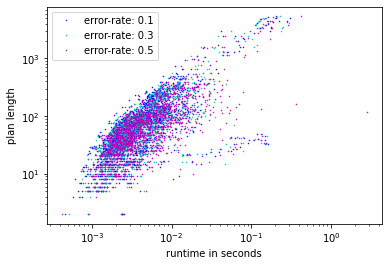

In [7]:
runtimes_all = []
length_all = []
diagnosis_lens = []
colors = ["b", "c", "m"]
for i, e in enumerate([0.1, 0.3, 0.5]):
    runtimes, _, plan_length, diagnosis_len = collect_data(e)
    runtimes_all += runtimes
    length_all += plan_length
    diagnosis_lens += diagnosis_len
    plt.plot(runtimes, plan_length, ".{}".format(colors[i]), 
             markersize=1, label="error-rate: {}".format(e))
plt.xscale("log")
plt.yscale("log")
plt.ylabel("plan length")
plt.xlabel("runtime in seconds")
plt.legend()
plt.show()

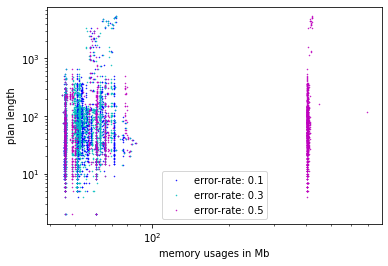

In [10]:
colors = ["b", "c", "m"]
for i, e in enumerate([0.1, 0.3, 0.5]):
    _, mem_usages, plan_length, diagnosis_len = collect_data(e)
    plt.plot(mem_usages, plan_length, ".{}".format(colors[i]), 
             markersize=1, label="error-rate: {}".format(e))
plt.xscale("log")
plt.yscale("log")
plt.ylabel("plan length")
plt.xlabel("memory usages in Mb")
plt.legend()
plt.show()

In [28]:
def parseFuzzyOps(line):
    #(name, operation, position, atom)
    line = line[1:-1]
    parts = line.split(":")
    name = parts[-1].strip()
    pattern = re.compile("[^\s]+\(.*\)")
    atom = pattern.search(parts[0]).group()
    body = re.sub(pattern, "", parts[0])
    body = [s for s in body.split(" ") if s.strip()]
    position = body[-1].strip()
    op = body[0].strip()
    assert(op == "Add" or op == "Remove")
    op = 1 if op == "Add" else 0
    if position == "Effs":
        atom_property = body[1].strip()
        assert(atom_property == "Atom" 
               or atom_property == "NegatedAtom")
        position = 1 if atom_property == "Atom" else 2
    elif position == "Pos-effs":
        position = 1
    elif position == "Neg-effs":
        position = 2
    elif position == "Prec":
        position = 0
    else:
        assert(False)
    return (name, op, position, atom)
    

In [32]:
def parseRepairOps(line):
    line = line[1:-1]
    line = line.split("|")[0]
    parts = line.split(":")[1:]
    name = parts[-1].strip()
    pattern = re.compile("[^\s]+\(.*\)")
    atom = pattern.search(parts[0]).group()
    body = re.sub(pattern, "", parts[0])
    body = [s for s in body.split(" ") if s.strip()]
    position = body[-1].strip()
    op = body[0].strip()
    assert(op == "Add" or op == "Remove")
    op = 1 if op == "Add" else 0
    assert(position == "Precondition" or position == "Effects")
    if position == "Precondition":
        position = 0
    else:
        atom_property = body[1].strip()
        assert(atom_property == "Atom" 
               or atom_property == "NegatedAtom")
        position = 1 if atom_property == "Atom" else 2
    return (name, op, position, atom)

In [44]:
def statistical_data(err_rate):
    num_total = 0
    num_correct = 0
    for domain_name in os.listdir(os.getcwd()):
        domain_dir = os.path.join(os.getcwd(), domain_name)
        if not os.path.isdir(domain_dir):
            continue
        for task_name in os.listdir(domain_dir):
            task_dir = os.path.join(domain_dir, task_name)
            diagnosis_file = os.path.join(task_dir, 
                                          "err-rate-{}".format(err_rate), 
                                          "diagnosis")
            fuzz_file = os.path.join(task_dir,
                                     "err-rate-{}".format(err_rate),
                                     "fuzz_ops.txt")
            if not os.path.exists(diagnosis_file):
                continue
            with open(diagnosis_file, "r") as f:
                lines = f.readlines()
                lines = lines[:-2]
                repairs = [parseRepairOps(line.strip("\n")) for line in lines]
            with open(fuzz_file, "r") as f:
                lines = f.readlines()
                fuzz_ops = [parseFuzzyOps(line.strip("\n")) for line in lines]
            num_total += len(repairs)
            for repair in repairs:
                for op in fuzz_ops:
                    if repair[0] == op[0] \
                            and repair[1] + op[1] == 1 \
                            and repair[2] == op[2] \
                            and repair[3] == op[3]:
                        num_correct += 1
                        break
    return (num_correct, num_total)